*********************************
# Features and Plots
*********************************

In this tutorial, we demostrate the calculation of basic features (standard events, filter, fits, ...) of the raw data events. We use for this the test data that we generated in the preceding notebook.

In [16]:
import cait as ai
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']  # we need this for a suitable resolution of the plots

For most notebooks, we define some constants at the beginning, to avoid typing the same strings over and over again.

In [2]:
path_data = 'test_data/'
fname = 'test_001'
channels_rdt = [0,1]
channels_h5 = [0,1]

The DataHandler class takes care of almost all calculations of features with its numerous implemented methods.

In [3]:
dh = ai.DataHandler(channels=channels_rdt)
dh.set_filepath(path_h5=path_data,
                fname=fname,
                appendix=False)  # this specifies, that the file does not have a "-P_Ch0..." appendix

DataHandler Instance created.


## Noise Power Spectrum

We start with calculating and plotting a Noise Power Spectrum. The baselines that are used for the calculation are cleaned beforhand, because in measured data the supposed noise baselines contain often accidentally coincident events or artifacts. For this we fit a polynomial of third order to the baselines and exclude the 5% of baselines with the largest fit error. 

At this point we should mention, that in measured data the noise power spectrum decays with 1/f (pink noise). Because our mock data simulation takes noise values from a normal distribution without taking care of a proper frequency spectrum, the amplitudes of the noise frequencies are constant (white noise).

Calculate NPS.


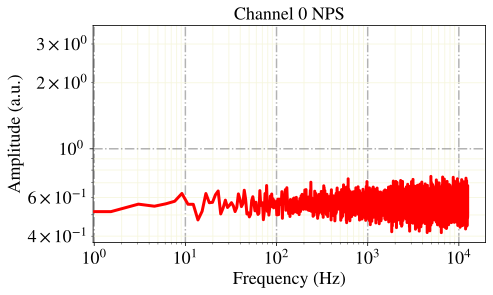

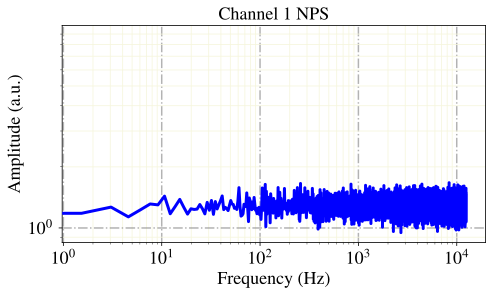

In [4]:
dh.calc_nps(percentile=95)
for c in channels_h5:
    dh.show_nps(channel=c, dpi=150, title='Channel {} NPS'.format(c))

## Baseline Cleaning

The above mentioned baseline cleaning can also be done independently from the calculation of a noise power spectrum. This is useful the tasks, where we need clean empty baselines, as the simulation of events to determine resolutions and cut efficiencies. For the fit of the polynomials we can downsample the high dimensional time series of the baselines, which does, applied with care, not impace the quality of the fit.

In [5]:
dh.calc_bl_coefficients(down=4)

Calculating Baseline Coefficients.
Fit Coeff and Rms calculated.


If we plot the fit errors of all baselines as a histogram, we see a Gaussian distribution. For our mock data, the distrution is indeed a beautiful gauss, while for real measured data we observe very ofter a log-normal-ish shape of the distribution. This is due to subthreshold events, drifts and a slight intrinsic non-gaussianity of the noise, that might originate in the fact, that we measure temperature and are therefore subject to the heat equation and its asymmetric solutions.

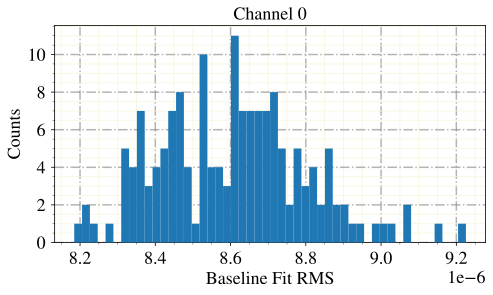

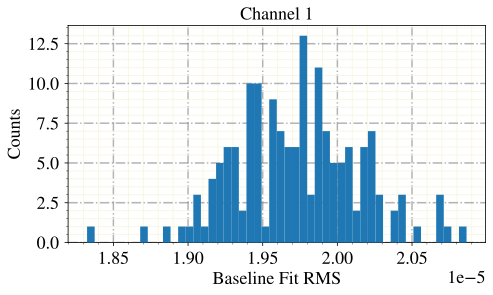

In [6]:
for c in [0,1]:
    dh.show_values(group='noise', key='fit_rms', bins=50, idx0=c, range=None,
                   xlabel='Baseline Fit RMS', ylabel='Counts', title='Channel {}'.format(c))

## Event Classes

Let's have a look at the events that were triggered from the hardware data aquisition! We know, that for many detector modules different kinds of pulse shapes appear. To find out, if there are multiple pulse shapes, we first extract the main parameters of the events, that were calculated when we did the data conversion. The main parameters are certain values describing the pulse shape, e.g. the value and position of the maximum of the voltage pulse trace, the positions of the starts of rise and decay, etc.

In [4]:
ph = dh.get('events', 'mainpar')[0,:,0]  # pulse height phonon channel
ph_light = dh.get('events', 'mainpar')[1,:,0]  # pulse height in light channel
decay_time = (dh.get('events','mainpar')[0,:,6] - dh.get('events','mainpar')[0,:,4])/dh.sample_frequency  # decay time phonon channel

We make a well educated guess about the different pulse shapes: A well known effect is, that particle recoils inside the absorber crystal have pulse shapes with a longer decay time than those in the carrier crystal. So we make a hard cut on the decay time parameter and call all events above absorber events, and those below carrier events.

In [5]:
absorbers = ai.cuts.LogicalCut(initial_condition=decay_time > 0.004)
carriers = ai.cuts.LogicalCut(absorbers.get_antiflag())

Lets see, if the cut achieved the desired result of separating the pulse shapes.

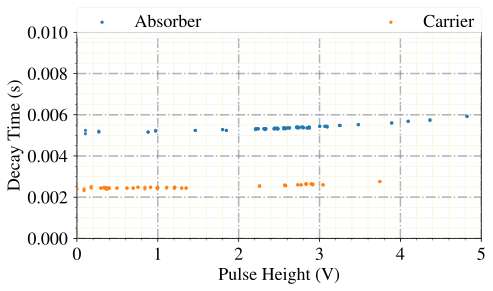

In [10]:
plt.close()
ai.styles.use_cait_style(dpi=150)
plt.scatter(ph[absorbers.get_flag()], decay_time[absorbers.get_flag()], marker='.', alpha=0.9, zorder=10, label='Absorber')
plt.scatter(ph[carriers.get_flag()], decay_time[carriers.get_flag()], marker='.', alpha=0.9, zorder=10, label='Carrier')
ai.styles.make_grid()
plt.xlabel('Pulse Height (V)')
plt.ylabel('Decay Time (s)')
plt.xlim([0,5])
plt.ylim([0,0.01])
legend = plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), mode="expand", borderaxespad=0., ncol=3)
for lh in legend.legendHandles:
    lh.set_alpha(1.0)
plt.show()

Well, this worked nicely! However, please be aware that events from acutal measurements are usually far more caotic and way harder to discriminate. For this purpose we will later on present some advanced methods for pulse shape disrimination.

But first, lets use the natural disrimination method of the CRESST and COSINUS experiment: The light yield. This parameter, which is exactly the ratio between the energy (pulse height) in the light channel and the phonen channel, takes advantage of the fact that nuclear recoils produce far less scintillation light than electron recoils, and make the distinction of different types of recoils within the detector therefore possible.

However, we are interested in distriminitaion of carrier and absorber events, and also for this purpose the light yield is a suitable discriminaing property. This is because carrier events produce no, or almost no scintillation light while absorber events do. Lets see if we can see the difference in the light yield plot.

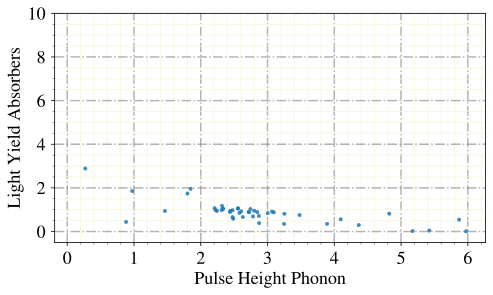

LY Plot created.


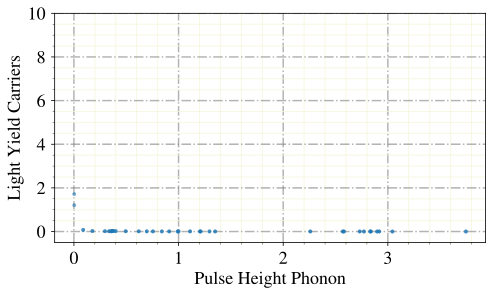

LY Plot created.


In [7]:
dh.show_ly(xlabel='Pulse Height Phonon', ylabel='Light Yield Absorbers', ylim=(-0.5,10), s=50, alpha=0.6, 
          only_idx=absorbers.get_flag())
dh.show_ly(xlabel='Pulse Height Phonon', ylabel='Light Yield Carriers', ylim=(-0.5,10), s=50, alpha=0.6, 
          only_idx=carriers.get_flag())

We obviously can! Lets now save this cut to the HDF5 dataset, we will use it in a later notebook again.

In [24]:
dh.apply_logical_cut(cut_flag=absorbers.get_flag(),
                     naming='decay_time_cut',
                     channel=0,
                     type='events',
                     delete_old=True)

Delete old decay_time_cut dataset


## Standard Event

A standard event is the sample-wise average of multiply triggered pulse events. This proceedure avarages out noise fluctuations and produces a clean pulse shape. We can apply several cuts on the pulses, before we calculate the standard event, from which we only choose the above defined decay time cut, as well as a upper and lower limit on the pulse height, to exclude overly noisy and saturated events.

92 Events handed.
6 left after PH cut.
6 Events used to generate Standardevent.
Parameter:  [-1.12045294  4.06797241  1.19720201  4.80191778  1.61070598  1.19720313]
92 Events handed.
16 left after PH cut.
16 Events used to generate Standardevent.
Parameter:  [ 0.66809242  3.86829156  2.2628326  29.31318826  3.31836476  2.57269489]
events SEV calculated.


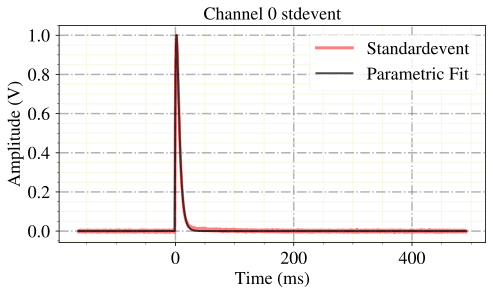

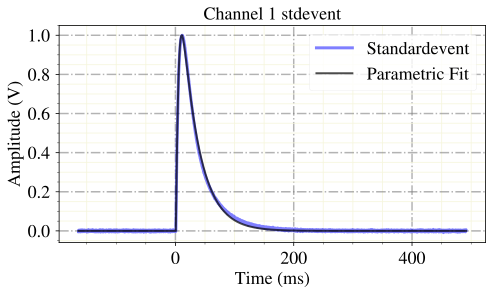

In [11]:
dh.calc_sev(pulse_height_interval=[[0.3, 1.5], [0.3, 1.5]],
            left_right_cutoff=None,
            rise_time_interval=None,
            decay_time_interval=None,
            onset_interval=None,
            t0_start=None,
            opt_start=False,
            use_idx=absorbers.get_idx())
for c in channels_h5:
    dh.show_sev(channel=c, dpi=150)

We can now fit this can standard event pulse shape to all triggered events, to get a better estimate of the true pulse height and onset than from the main parameters. For this we can downsample the time series of the event a bit, to reduce the computational complexity of the fit. In practice, moderate downsampling has proven to not reduce the accuracy of the fit parameters.

In [12]:
down=4
dh.apply_sev_fit(down=4, name_appendix='_down{}'.format(down), processes=4,
                 truncation_level=[2, 1.5], events_to_fit=160, verb=True)

Calculating SEV Fit.
Fitting channel 0.


100%|██████████| 160/160 [00:12<00:00, 12.36it/s]

Fitting channel 1.



100%|██████████| 160/160 [00:12<00:00, 12.46it/s]


Done.


A multi-purpose quality cut on the pulse shape it the fit error of the standard event fit. The error will typically be larger, if the triggered events looks different than the standard event. Let's do a plot and look at this effect!

In [13]:
ph_fitted = dh.get('events', 'sev_fit_par_down{}'.format(down))[0,:,0]
fit_rms = dh.get('events', 'sev_fit_rms_down{}'.format(down))[0]

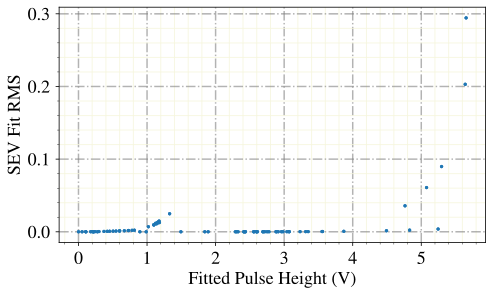

In [14]:
dh.show_scatter(groups=['events', 'events'],
                keys=['sev_fit_par_down{}'.format(down), 'sev_fit_rms_down{}'.format(down)],
                title=None,
                idx0s=[0, 0],  # 0 is the phonon channel
                idx2s=[0, None],
                xlabel='Fitted Pulse Height (V)',
                ylabel='SEV Fit RMS',
                marker='.',
                )

We can clearly see two bands in this visualization, which event more point to the existance of two pulse shapes.

But now we really want to know, how this second pulse shape looks like. Therefore also calculate a standard event for the carrier event.

68 Events handed.
68 left after PH cut.
68 Events used to generate Standardevent.
Parameter:  [ -2.38988953   1.71258441   1.62633403 136.48745778   0.38338796
   2.23185475]
events SEV calculated.


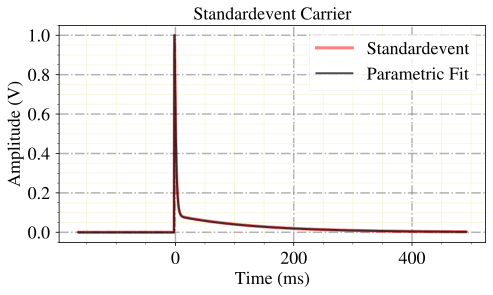

In [15]:
dh.calc_exceptional_sev(naming='carrier',
                        channel=0,  # it is in the phonon channel
                        use_idx=carriers.get_idx())
dh.show_exceptional_sev(naming='carrier', dpi=150, title='Standardevent Carrier')

We can see, that it indeed looks very different, characterized by its fast rise and decay in one pulse shape component and a very long tail in the other.

## Optimum Filter

In CRESST, as well as in many other rare event search experiments, a matched filer, synonym to optimum filter, is the standard for the triggering and pulse height estimation of events. This is a filter, built from the ratio of the standard event and the noise power spectrum in fourier space, that provides the maximum likelihood estimators for the pulse height and peak position. Lets look at it's power spectrum!

CREATE OPTIMUM FILTER.
OF updated.


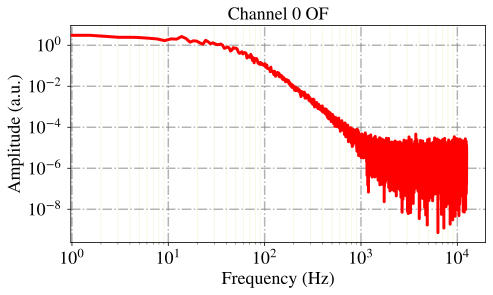

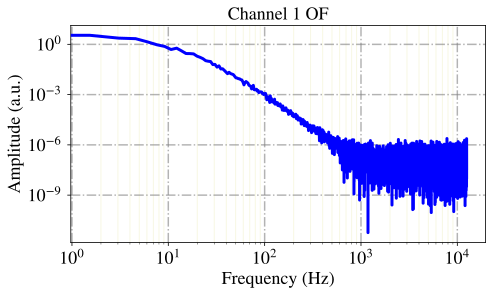

In [16]:
dh.calc_of()
for c in channels_h5:
    dh.show_of(channel=c, dpi=150)

When the optimum filter is used for triggering, the calculation of the FFTs in real time for all channels is very cost intensive. From experiments we know, that reasonable downsampling of the record window does not effect the trigger efficiency. For this purpose, we also calculate the downsampled optimum filter.

CREATE OPTIMUM FILTER.
OF updated.


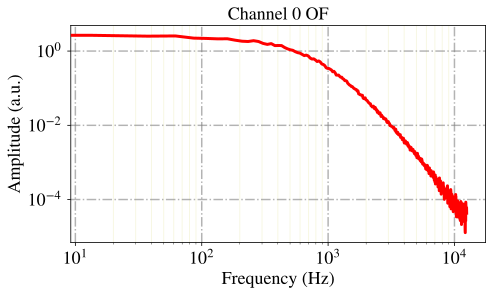

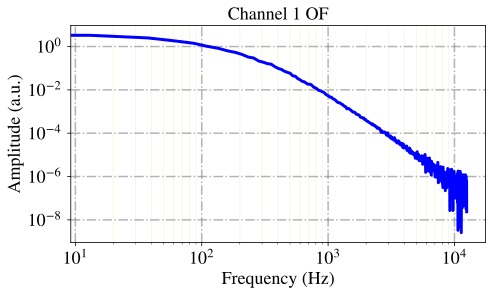

In [17]:
dh.calc_of(down=16)
for c in channels_h5:
    dh.show_of(down=16, channel=c, dpi=150)

We apply now the optimum filter to all events and calculate so the maximum likelihood estimates for their pulse height.

In [18]:
dh.apply_of()

Calculating OF Heights.


## Main Parameters

Just in case we want to recalculate the main parameters, that were calculated when we did the data conversion, we can always do so.

In [19]:
dh.calc_mp()

CALCULATE MAIN PARAMETERS.


There is also an additional set of main parameters, including the filtered maximum and position, the variance and mean of several parts of the pulse trace, as well as the maximum and minimum both of the raw array and its derivative.

In [20]:
dh.calc_additional_mp()

CALCULATE ADDITIONAL MAIN PARAMETERS.


## Spectrum

We are typically interested in the energy spectrum of a measurement. The recoil energy corresponds in the non-saturated regoin of the detector almost linearly to the pulse height. We plot the calculated pulse height spectrum of the absorber events with three different methods: The main paramters (maximum of the time series), the optimum filter and the standard event fit.

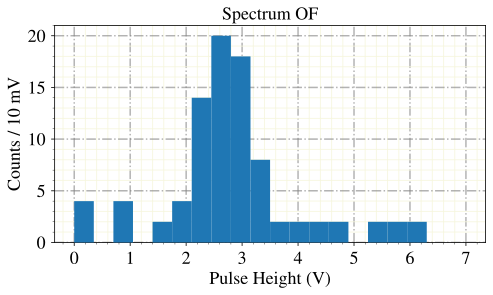

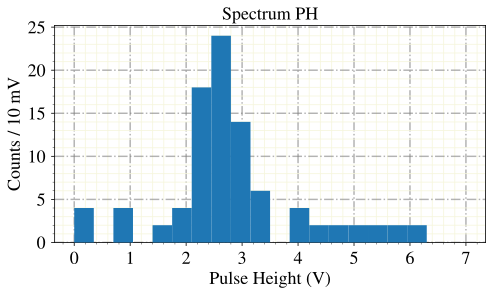

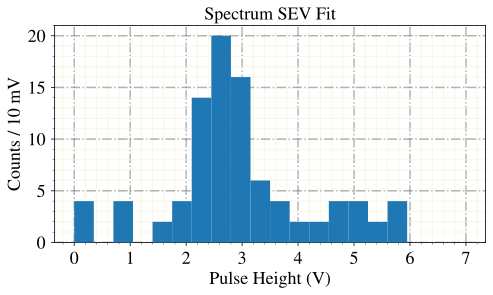

In [21]:
channel=0

dh.show_values(group='events', key='of_ph', bins=20, idx0=channel, cut_flag=absorbers.get_flag(), range=(0,7),
               xlabel='Pulse Height (V)', ylabel='Counts / 10 mV', title='Spectrum OF')
dh.show_values(group='events', key='mainpar', bins=20, idx0=channel, idx2=0, cut_flag=absorbers.get_flag(), range=(0,7),
               xlabel='Pulse Height (V)', ylabel='Counts / 10 mV', title='Spectrum PH')
dh.show_values(group='events', key='sev_fit_par_down{}'.format(4), bins=20, idx0=channel, idx2=0, cut_flag=absorbers.get_flag(), range=(0,7),
               xlabel='Pulse Height (V)', ylabel='Counts / 10 mV', title='Spectrum SEV Fit')

With all methods we see a clear peak in the data, accompanied by a soft exonential rise for low energies. This kind of spectrum is typical for measurements, that are taken with some calibration source close to the detector.

Now lets compare the different methods for pulse height estimation in more detail: The scatter plot below shows again clearly two bands of events. This shows, that also the difference in the estimation of the pulse height can be taken for event discrimination. Best visible are the two lines with different slopes from the OF/Event Height scattering. We can trust the optimum filter pulse height estimator to always produce lines, not only bands, because the FFT which is used for the filtering is a linear transformation. Down to relatively low energies, we could with these two pulse height estimators alone perform reasonable pulse shape discrimination.

We like to call this a Pulse Height Difference (PHD) cut.

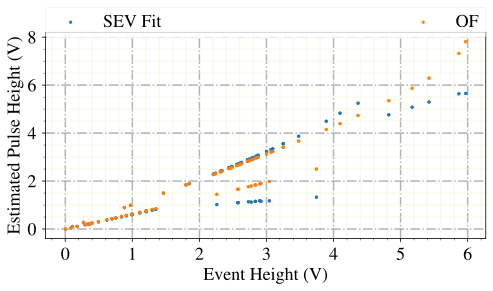

In [22]:
ph = dh.get('events', 'mainpar')[0,:,0]
ph_fitted = dh.get('events', 'sev_fit_par_down{}'.format(4))[0,:,0]
ph_filter = dh.get('events', 'of_ph')[0]

plt.close()
ai.styles.use_cait_style(dpi=150)
plt.scatter(ph, ph_fitted, marker='.', alpha=0.9, zorder=10, label='SEV Fit')
plt.scatter(ph, ph_filter, marker='.', alpha=0.9, zorder=10, label='OF')
ai.styles.make_grid()
plt.xlabel('Event Height (V)')
plt.ylabel('Estimated Pulse Height (V)')
#plt.xlim([0,5])
#plt.ylim([0,0.01])
legend = plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), mode="expand", borderaxespad=0., ncol=3)
for lh in legend.legendHandles:
    lh.set_alpha(1.0)
plt.show()

## PCA

Another standard method in the field of data science is the Principal Component Analysis. We as physicists would naturally call it a singular value decomposition, as we learned it in linear algebra, but here we shall do as the romans do.

The PCA calculates a number of principal components (eigenvectors) of the data matrix X[event_index, sample_index]. The sum of the corresponding eigenvectors are then the share of the variance in the data, that is explained by the principal components. We typically project all events in the subspace, spanned by the pricipal components. The produces a dimensionality reduction, while simultaniously retaining as much variance as possible with a linear transformation.

The calculation of eigenvectors of large data matrices is computationally expensive, because the cost grows quadratically with the size. There are modern approximative algorithms, that reduce this cost significantly, which we use. However, to keep the method also accessible for very large datasets, we offer on the one hand the possibility to downsample the events for the calculation, and on the other hand to do the calculation only on a subset of eventy, while calculating the projection for all. The downsampling we use here with a factor 2, the later method could be used by handing a list of indices on the fit_idx argument.

In [23]:
dh.apply_pca(nmbr_components=2, down=2, fit_idx=None)

Channel  0
Explained Variance:  [0.88291756 0.099749  ]
Singular Values:  [185.87997545  62.47795526]
Channel  1
Explained Variance:  [0.98909451 0.01028236]
Singular Values:  [300.9671555   30.68645031]


The principal components, back transformed to the basis system of the sample indices, reveal the two linear templates that unify most variance-describing features within all events. Not surprisingly, these look very much like pulses, with minor shape differences.

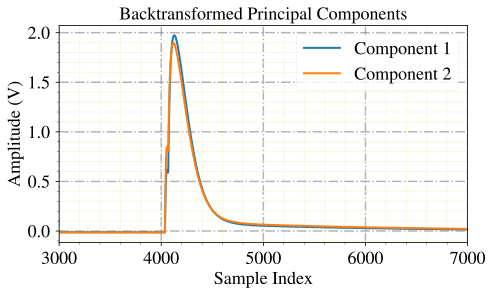

In [24]:
components = dh.get('events', 'pca_components')

plt.close()
ai.styles.use_cait_style(dpi=150)
for i, comp in enumerate(components[0]):
    plt.plot(comp, label='Component {}'.format(i+1))
plt.title('Backtransformed Principal Components')
ai.styles.make_grid()
plt.xlabel('Sample Index')
plt.ylabel('Amplitude (V)')
plt.xlim(3000, 7000)
plt.legend()
plt.show()

We could also try to use the PCA event reconstruction error, that is the information we lose by the projection in the subspace, for pulse shape discrimintaion. This however works in our scenario only well for the strongly saturated events, which deviate from the pulse shape and cannot be described by linear scaling of a template very well.

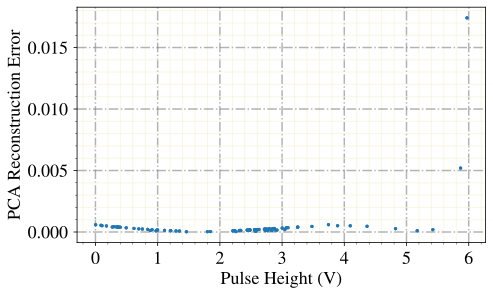

In [25]:
dh.show_scatter(groups=['events', 'events'],
                keys=['mainpar', 'pca_error'],
                title=None,
                idx0s=[0, 0],  # 0 is the phonon channel
                idx2s=[0, None],
                xlabel='Pulse Height (V)',
                ylabel='PCA Reconstruction Error',
                marker='.',
                )

A common visualization method is, to plot the subspace spanned by the first two principal components. In our case, this methods works very well and we see clearly two bands for the two different events types.

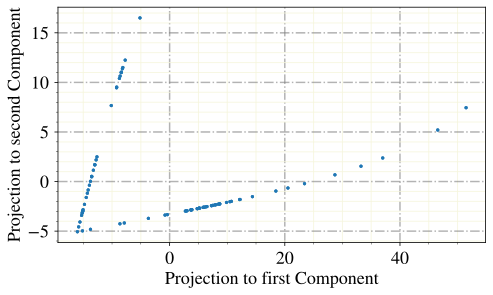

In [26]:
dh.show_scatter(groups=['events', 'events'],
                keys=['pca_projection', 'pca_projection'],
                title=None,
                idx0s=[0, 0],  # 0 is the phonon channel
                idx2s=[0, 1],
                xlabel='Projection to first Component',
                ylabel='Projection to second Component',
                marker='.',
                )

Please forward questions and correspondence about this notebook to felix.wagner(at)oeaw.ac.at.